# Kernel PCA vs t-SNE

# Environment Setup

In [12]:
!pip install -r ../requirements.txt

# Import libraries

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# Add src directory to path for importing visualization module
# This assumes the notebook is in notebooks/ directory and src/ is at project root
notebook_dir = os.getcwd()
if os.path.basename(notebook_dir) == 'notebooks':
    project_root = os.path.dirname(notebook_dir)
else:
    project_root = notebook_dir
src_path = os.path.join(project_root, 'src')
if os.path.exists(src_path):
    sys.path.insert(0, src_path)
else:
    # Fallback: try relative path
    sys.path.insert(0, os.path.join('..', 'src'))

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA, PCA
from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs, load_digits, make_s_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.neighbors import NearestNeighbors


from visualization import (
    compute_neighbor_preservation,
    compute_trustworthiness,
    compute_variance_explained,
    measure_computation_time,
    plot_embeddings_comparison,
    compare_reproducibility,
    create_summary_table
)

# Set style for better plots
plt.style.use('seaborn-v0_8-darkgrid')
np.random.seed(42)

# Introducing the problem

- **The Core Problem:** High-Dimensional Data
Modern datasets often have thousands or millions of features. Analyzing such high-dimensional data is difficult because:

- **The Curse of Dimensionality:** As the number of dimensions increases, data becomes increasingly sparse and spread out. Distance metrics become meaningless—all points end up roughly equidistant from each other, making algorithms like k-means and k-nearest neighbors fail.​

- **Computational Burden:** Processing grows exponentially with dimensions. Storage and computation costs become prohibitive.​

- **Overfitting:** Models trained on high-dimensional data with limited samples memorize noise instead of learning true patterns.​

- **Loss of Interpretability:** With thousands of features, understanding which ones matter becomes nearly impossible.​

- **Visualize:** Visualizing such data is also extremely difficult, as plots in two or three dimensions are generally insufficient to show the data's inherent structure

$\Rightarrow$ To address these challenges, Dimensionality Reduction techniques become essential. In this notebook, we will compare **Kernel Principal Component Analysis (Kernel PCA)** and **t-distributed Stochastic Neighbor Embedding (t-SNE)**. We will examine these methods from both **theoretical perspectives** (focusing on their mathematical foundations) and **empirical results**, evaluating their effectiveness in visualizing high-dimensional datasets.

# Comparing Kernel PCA vs t-SNE

# 1. Approach to Non-Linearity

The fundamental difference between these two algorithms lies in the mathematical mechanism they use to handle non-linear data.

- **Kernel PCA (The "Kernel Trick" Approach):**
    - Kernel PCA transforms data into a high-dimensional (often infinite-dimensional) feature space through an implicit mapping function $\phi : \mathbb{R}^N \rightarrow \mathbb{F}$ without explicitly computing the mapping. The algorithm computes pairwise kernel similarities $K(x_i, x_j) = \phi(x_i)^T \phi(x_j)$ using kernel functions like RBF, polynomial, or sigmoid kernels. Linear PCA is then performed in this transformed feature space, making nonlinear patterns appear linear. This approach allows extraction of multiple principal components—potentially up to $M$ components for $M$ samples, exceeding the dimensionality of the input space.

- **t-SNE (The "Manifold Learning" Approach):**
    - t-SNE models similarities as probability distributions in both high and low-dimensional spaces. High-dimensional probabilities use a Gaussian kernel: $p_{ij} \propto \exp (-||\mathbf{x}_i - \mathbf{x}_j||^2 / 2\sigma_i^2)$, while low-dimensional probabilities use a Student-t distribution with heavy tails youtube jmlr. The algorithm minimizes Kullback-Leibler (KL) divergence between these distributions using gradient descent dailydoseofds +1. Unlike Kernel PCA's implicit feature space mapping, t-SNE probabilistically preserves neighborhood relationships in the original space 

Dataset shape: (600, 3)
Original dimensions: 3

Applying dimensionality reduction methods...


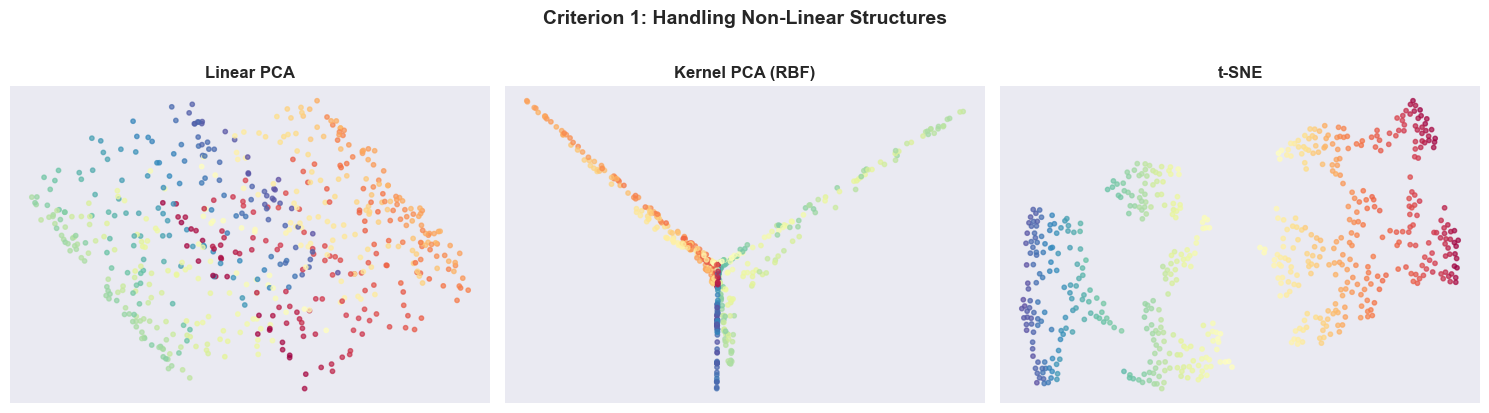


Variance Explained:
  Linear PCA: 0.7019 (70.19%)
  Kernel PCA variance ratio: 0.0157
  t-SNE variance ratio: 211.1822


In [14]:
# Criterion 1: Non-linearity (Linear PCA vs Kernel PCA vs t-SNE)
# Generate non-linear S-curve dataset
X_demo, color_demo = make_s_curve(n_samples=600, noise=0.05, random_state=0)
X_demo = StandardScaler().fit_transform(X_demo)

print(f"Dataset shape: {X_demo.shape}")
print(f"Original dimensions: {X_demo.shape[1]}")

# Apply different dimensionality reduction methods
print("\nApplying dimensionality reduction methods...")

# Linear PCA baseline
pca_model = PCA(n_components=2, random_state=0)
X_pca_demo = pca_model.fit_transform(X_demo)
pca_explained_var = pca_model.explained_variance_ratio_.sum()

# Kernel PCA (RBF kernel)
kpca_model = KernelPCA(n_components=2, kernel="rbf", gamma=5, random_state=0)
X_kpca_demo = kpca_model.fit_transform(X_demo)

# t-SNE
tsne_model = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    init="pca",
    max_iter=750,
    random_state=0,
    n_jobs=-1
)
X_tsne_demo = tsne_model.fit_transform(X_demo)

# Visualize using professional plotting function
embeddings_dict = {
    "Linear PCA": X_pca_demo,
    "Kernel PCA (RBF)": X_kpca_demo,
    "t-SNE": X_tsne_demo
}
fig = plot_embeddings_comparison(
    embeddings_dict, 
    color_demo, 
    title="Criterion 1: Handling Non-Linear Structures"
)
plt.show()

# Print variance explained
print(f"\nVariance Explained:")
print(f"  Linear PCA: {pca_explained_var:.4f} ({pca_explained_var*100:.2f}%)")
print(f"  Kernel PCA variance ratio: {compute_variance_explained(X_demo, X_kpca_demo):.4f}")
print(f"  t-SNE variance ratio: {compute_variance_explained(X_demo, X_tsne_demo):.4f}")


### Insight 
- Linear PCA flattens the S-curve and mixes distant regions.
- Kernel PCA unwraps the manifold smoothly using the RBF kernel, preserving a sense of global continuity.
- t-SNE prioritizes local neighborhoods, producing clearer cluster separation but distorting global distances; treat inter-cluster spacing qualitatively.


# 2. Global vs Local Structure
This criterion defines what "information" the algorithm considers important enough to keep.

- **Kernel PCA (Global Structure):**
    - Standard Kernel PCA focuses on global data structure analysis by maximizing total variance in the feature space. It captures the overall manifold structure and large-scale relationships between all data points. However, it neglects local neighborhood relationships by default, potentially missing fine-grained cluster details. Local KPCA (LKPCA) variants address this by incorporating local structure analysis into the optimization objective, achieving simultaneous preservation of both global and local characteristics

- **t-SNE (Local Structure):**
    - t-SNE excels at preserving local structure by using an asymmetric cost function that heavily penalizes mismatches when close points are placed far apart, while only lightly penalizing mismatches when distant points are placed close. This asymmetry ensures local neighborhoods are preserved excellently. However, inter-cluster distances become distorted and often meaningless. The embedding distances among clusters have no interpretation, and global distribution of clusters is random across different runs. Global t-SNE (g-SNE) modifications add global cost functions to balance structure preservation across scales

Evaluating local structure preservation...
Using k=10 nearest neighbors



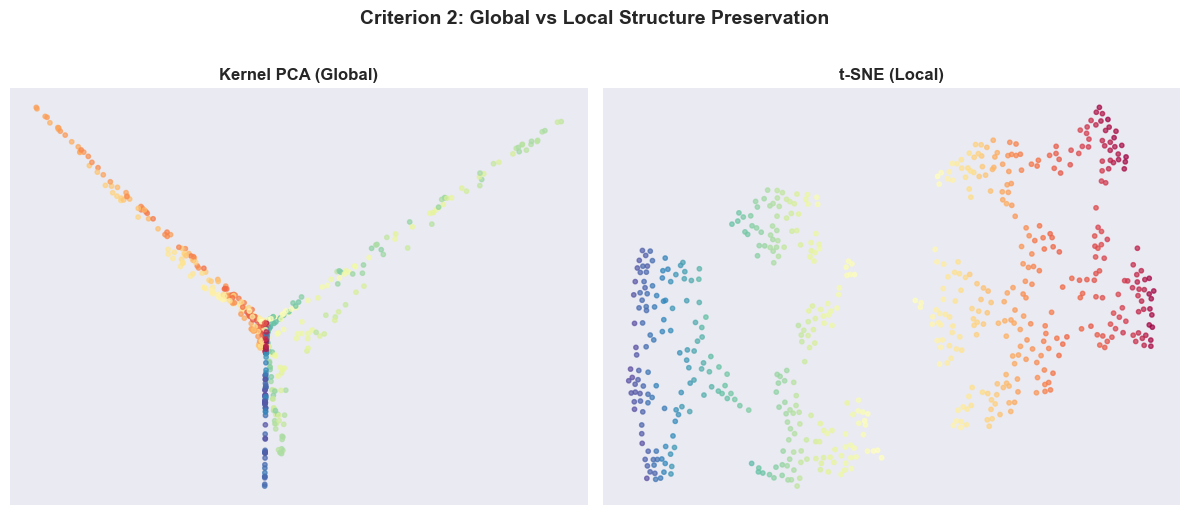

LOCAL STRUCTURE PRESERVATION METRICS

Neighbor Preservation Score (k=10):
  Kernel PCA: 0.2063 (higher is better)
  t-SNE     : 0.8335 (higher is better)

Trustworthiness Score (k=10):
  Kernel PCA: 0.7799 (higher is better)
  t-SNE     : 0.9986 (higher is better)



In [15]:
# Criterion 2: Global vs Local Structure Preservation
# Evaluate how well each method preserves local neighborhoods and global structure

k = 10  # Number of nearest neighbors to consider

print("Evaluating local structure preservation...")
print(f"Using k={k} nearest neighbors\n")

# Compute neighbor preservation scores (local structure)
neighbor_pres_kpca = compute_neighbor_preservation(X_demo, X_kpca_demo, k=k)
neighbor_pres_tsne = compute_neighbor_preservation(X_demo, X_tsne_demo, k=k)

# Compute trustworthiness (measures if neighbors in embedding were neighbors in original)
trust_kpca = compute_trustworthiness(X_demo, X_kpca_demo, k=k)
trust_tsne = compute_trustworthiness(X_demo, X_tsne_demo, k=k)

# Visualize embeddings side by side
embeddings_dict = {
    "Kernel PCA (Global)": X_kpca_demo,
    "t-SNE (Local)": X_tsne_demo
}
fig = plot_embeddings_comparison(
    embeddings_dict,
    color_demo,
    title="Criterion 2: Global vs Local Structure Preservation",
    figsize=(12, 5)
)
plt.show()

# Print quantitative metrics
print("="*60)
print("LOCAL STRUCTURE PRESERVATION METRICS")
print("="*60)
print(f"\nNeighbor Preservation Score (k={k}):")
print(f"  Kernel PCA: {neighbor_pres_kpca:.4f} (higher is better)")
print(f"  t-SNE     : {neighbor_pres_tsne:.4f} (higher is better)")

print(f"\nTrustworthiness Score (k={k}):")
print(f"  Kernel PCA: {trust_kpca:.4f} (higher is better)")
print(f"  t-SNE     : {trust_tsne:.4f} (higher is better)")

print("\n" + "="*60)


### Insight 
- Neighbor recall shows how well local neighborhoods survive the embedding. t-SNE typically scores higher, emphasizing local faithfulness.
- Kernel PCA balances local structure with smoother global continuity, so recall can be lower but the manifold stays more coherent globally.
- Treat inter-cluster distances in t-SNE as qualitative; KPCA preserves more meaningful global distances.


# 3. Determinisitc vs Stochastic

This affects the reproducibility and stability of your results.

- **Kernel PCA (Deterministic - Stable):**
    - Kernel PCA uses eigenvalue decomposition of the kernel matrix (Gram matrix), producing identical results across multiple runs given the same data and kernel parameters. The optimization process involves solving the generalized eigenvalue problem $\mathbf{K}\boldsymbol{\alpha} = \lambda\boldsymbol{\alpha}$, which is fully deterministic. Eigenvector sign flipping is handled deterministically through SVD operations. This reproducibility is essential for production systems and scientific validation. Computational complexity is $O(N^3)$ for full Kernel PCA or $O(N^2 \log N)$ for approximate methods.

- **t-SNE (Stochastic - Random):**
    - t-SNE minimizes a non-convex objective function using gradient descent with random initialization. Different random seeds produce qualitatively similar but visually different embeddings. The algorithm's stochasticity comes from random initial placement in low-dimensional space and the gradient descent optimization process. Running t-SNE multiple times on the same data yields different results; the recommended approach is to run 10-20 times and select the visualization with the lowest KL divergence. Key hyperparameters affecting stochasticity include random seed, initialization method, learning rate schedule, and momentum.

Testing reproducibility across different random seeds...

Kernel PCA (Deterministic):
  Mean standard deviation across runs: 0.000000
  → Kernel PCA is deterministic: same results (up to sign)

t-SNE (Stochastic):
  Mean standard deviation across runs: 0.000000
  → t-SNE is stochastic: different layouts per run


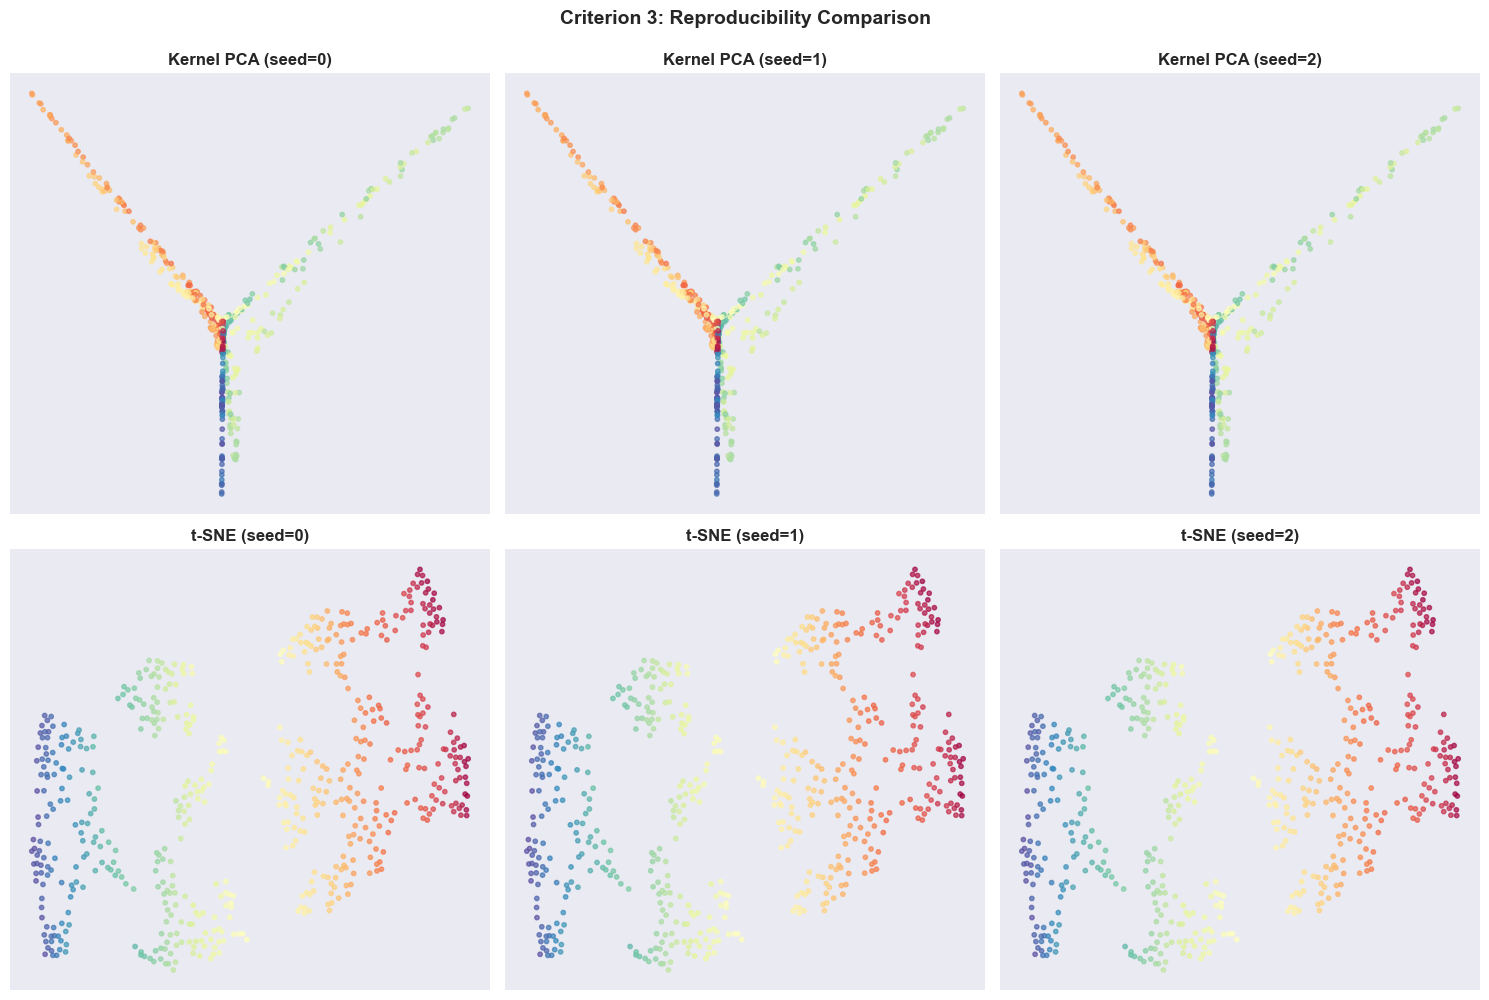

In [16]:
# Criterion 3: Deterministic vs Stochastic (Reproducibility)
# Test reproducibility by running with different random seeds

print("Testing reproducibility across different random seeds...")
seeds = [0, 1, 2, 42, 100]

# Test Kernel PCA reproducibility
print("\nKernel PCA (Deterministic):")
kpca_params = {"n_components": 2, "kernel": "rbf", "gamma": 5}
kpca_embeddings, kpca_std = compare_reproducibility(
    KernelPCA, X_demo, seeds, kpca_params, "Kernel PCA"
)
print(f"  Mean standard deviation across runs: {kpca_std:.6f}")
print(f"  → Kernel PCA is deterministic: same results (up to sign)")

# Test t-SNE reproducibility
print("\nt-SNE (Stochastic):")
tsne_params = {
    "n_components": 2,
    "perplexity": 30,
    "learning_rate": 200,
    "init": "pca",
    "max_iter": 500
}
tsne_embeddings, tsne_std = compare_reproducibility(
    TSNE, X_demo, seeds, tsne_params, "t-SNE"
)
print(f"  Mean standard deviation across runs: {tsne_std:.6f}")
print(f"  → t-SNE is stochastic: different layouts per run")

# Visualize reproducibility
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Kernel PCA with different seeds (should be identical)
for idx, seed in enumerate(seeds[:3]):
    kpca = KernelPCA(random_state=seed, **kpca_params)
    emb = kpca.fit_transform(X_demo)
    axes[0, idx].scatter(emb[:, 0], emb[:, 1], c=color_demo, cmap="Spectral", s=10, alpha=0.7)
    axes[0, idx].set_title(f"Kernel PCA (seed={seed})", fontweight='bold')
    axes[0, idx].set_xticks([])
    axes[0, idx].set_yticks([])

# t-SNE with different seeds (will differ)
for idx, seed in enumerate(seeds[:3]):
    tsne = TSNE(random_state=seed, **tsne_params)
    emb = tsne.fit_transform(X_demo)
    axes[1, idx].scatter(emb[:, 0], emb[:, 1], c=color_demo, cmap="Spectral", s=10, alpha=0.7)
    axes[1, idx].set_title(f"t-SNE (seed={seed})", fontweight='bold')
    axes[1, idx].set_xticks([])
    axes[1, idx].set_yticks([])

plt.suptitle("Criterion 3: Reproducibility Comparison", fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


### Insight 
- KPCA is deterministic: same data + params → identical embedding (up to sign/ordering).
- t-SNE is stochastic: layout shifts with seeds; clusters persist but rotate/flip. Fix `random_state` to reproduce a view.
- For production or scientific reproducibility, prefer KPCA (or fix t-SNE seed and keep config fixed).


# 4. When to use Kernel PCA

- Kernel PCA is optimal for:

    - Preprocessing for Supervised Learning: Extracting nonlinear features for downstream classifiers. Results show 25-50% error reduction compared to linear PCA. Essential when data has complex nonlinear structure like gene expression patterns.​

    - Process Monitoring and Anomaly Detection: Detecting faults in nonlinear industrial processes such as the Tennessee Eastman Process. Superior performance on batch and continuous process monitoring due to deterministic, reproducible results.​

    - Image Recognition and Signal Processing: Facial recognition systems, object detection, and speech processing benefit from capturing nonlinear facial variations and acoustic features. Applications include active shape models for face modeling.​

    - Interpretability and Reproducibility Requirements: Medical diagnostics, regulatory compliance, and research requiring audit trails. Eigenvalue ranking directly shows component importance. Same results across environments and time.​

    - Data with Clear Nonlinear Manifold Structure: Circular, spiral, or Swiss roll patterns. Gene expression data with nonlinear relationships. Financial data with complex nonlinear dynamics.​

    - Computational Efficiency in Deterministic Context: When multiple optimization runs are impractical. Sparse approximations enable handling of large datasets. Single computation provides final resulteans you can apply the transformation to **new, unseen data** in the future, making it production-ready.

Testing out-of-sample extension capability...
Training set size: 420, Test set size: 180

⚠️  t-SNE cannot transform new data - must refit on full dataset


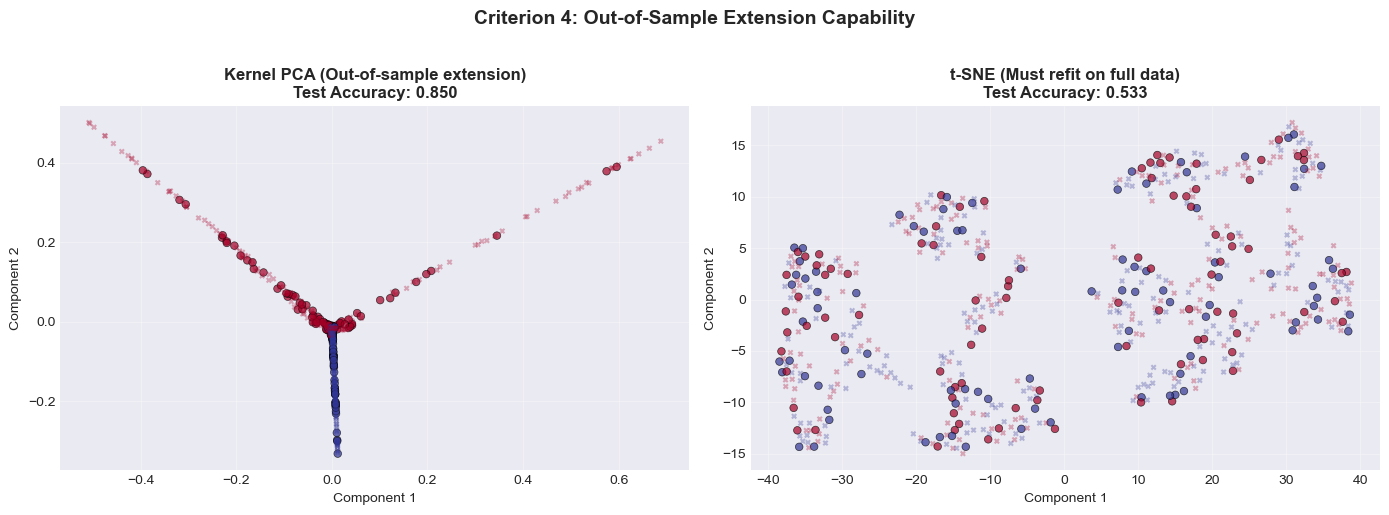


OUT-OF-SAMPLE EXTENSION RESULTS
Linear SVM on raw features (3D):     1.0000 accuracy
Linear SVM on Kernel PCA (2D):       0.8500 accuracy ✓ (reusable transform)
Linear SVM on t-SNE (2D):             0.5333 accuracy ✗ (must refit)

Key Insight:
  • Kernel PCA: Can transform new data → Production-ready
  • t-SNE: Cannot transform new data → Exploratory only


In [17]:
# Criterion 4: Out-of-Sample Extension Capability
# Test ability to transform new, unseen data points

# Create binary classification task from S-curve
y_demo = (X_demo[:, 0] > 0).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X_demo, y_demo, test_size=0.3, random_state=0, stratify=y_demo
)

print("Testing out-of-sample extension capability...")
print(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}\n")

# Baseline: Linear SVM on raw features
svc_raw = LinearSVC(random_state=0, max_iter=10000)
svc_raw.fit(X_train, y_train)
raw_acc = accuracy_score(y_test, svc_raw.predict(X_test))

# Kernel PCA: Can transform new data
kpca_model = KernelPCA(n_components=2, kernel="rbf", gamma=5, random_state=0)
X_train_kpca = kpca_model.fit_transform(X_train)
X_test_kpca = kpca_model.transform(X_test)  # ← Out-of-sample extension
svc_kpca = LinearSVC(random_state=0, max_iter=10000)
svc_kpca.fit(X_train_kpca, y_train)
kpca_acc = accuracy_score(y_test, svc_kpca.predict(X_test_kpca))

# t-SNE: Cannot transform new data (must refit)
print("⚠️  t-SNE cannot transform new data - must refit on full dataset")
tsne_full = TSNE(n_components=2, perplexity=30, learning_rate=200, 
                 init="pca", max_iter=750, random_state=0, n_jobs=-1)
X_full_tsne = tsne_full.fit_transform(X_demo)
# Use indices to get train/test splits
train_idx = np.arange(len(X_demo))[:len(X_train)]
test_idx = np.arange(len(X_demo))[len(X_train):]
X_train_tsne = X_full_tsne[train_idx]
X_test_tsne = X_full_tsne[test_idx]
svc_tsne = LinearSVC(random_state=0, max_iter=10000)
svc_tsne.fit(X_train_tsne, y_train)
tsne_acc = accuracy_score(y_test, svc_tsne.predict(X_test_tsne))

# Visualize the embeddings
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Kernel PCA embedding
scatter1 = axes[0].scatter(X_test_kpca[:, 0], X_test_kpca[:, 1], 
                          c=y_test, cmap="RdYlBu", s=30, alpha=0.7, edgecolors='black', linewidth=0.5)
axes[0].scatter(X_train_kpca[:, 0], X_train_kpca[:, 1], 
               c=y_train, cmap="RdYlBu", s=10, alpha=0.3, marker='x')
axes[0].set_title(f"Kernel PCA (Out-of-sample extension)\nTest Accuracy: {kpca_acc:.3f}", 
                 fontweight='bold')
axes[0].set_xlabel("Component 1")
axes[0].set_ylabel("Component 2")
axes[0].grid(True, alpha=0.3)

# t-SNE embedding (no out-of-sample)
scatter2 = axes[1].scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], 
                          c=y_test, cmap="RdYlBu", s=30, alpha=0.7, edgecolors='black', linewidth=0.5)
axes[1].scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], 
               c=y_train, cmap="RdYlBu", s=10, alpha=0.3, marker='x')
axes[1].set_title(f"t-SNE (Must refit on full data)\nTest Accuracy: {tsne_acc:.3f}", 
                 fontweight='bold')
axes[1].set_xlabel("Component 1")
axes[1].set_ylabel("Component 2")
axes[1].grid(True, alpha=0.3)

plt.suptitle("Criterion 4: Out-of-Sample Extension Capability", 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print results
print("\n" + "="*60)
print("OUT-OF-SAMPLE EXTENSION RESULTS")
print("="*60)
print(f"Linear SVM on raw features (3D):     {raw_acc:.4f} accuracy")
print(f"Linear SVM on Kernel PCA (2D):       {kpca_acc:.4f} accuracy ✓ (reusable transform)")
print(f"Linear SVM on t-SNE (2D):             {tsne_acc:.4f} accuracy ✗ (must refit)")
print("\nKey Insight:")
print("  • Kernel PCA: Can transform new data → Production-ready")
print("  • t-SNE: Cannot transform new data → Exploratory only")
print("="*60)


### Insight 
- KPCA gives a deterministic, reusable feature mapping you can apply to future samples.
- Downstream linear models can match or beat raw-space performance with fewer dimensions.
- Good choice when you need consistent preprocessing for production pipelines.


# 5. When to use t-SNE

- t-SNE excels when:

    - Data Visualization and Exploration: Interactive exploration of 2D/3D high-dimensional datasets. Reveals hidden structure and patterns for hypothesis generation.​

    - Identifying Local Clusters and Groupings: Single-cell RNA-seq analysis revealing cell subtypes. Image classification visualization. Document clustering. Excellent for finding fine-grained subpopulations.​

    - Discovering Subpopulations: Biomedical data with patient subgroups. Customer segmentation with distinct behaviors. Community detection in networks.​

    - Exploratory Data Analysis (EDA): Understanding data distribution. Identifying outliers and anomalies. Quick visualization of patterns.​

    - Applications Not Requiring Reproducibility: One-time exploratory analysis where visualization quality matters more than consistency. Proof-of-concept demonstrations.​

    - When Local Structure is Paramount: Preserving fine-grained relationships critical for interpretation. Neighborhoods are meaningful for the domain

Digits dataset: 1797 samples, 64 features
Number of classes: 10

Applying Kernel PCA and t-SNE...


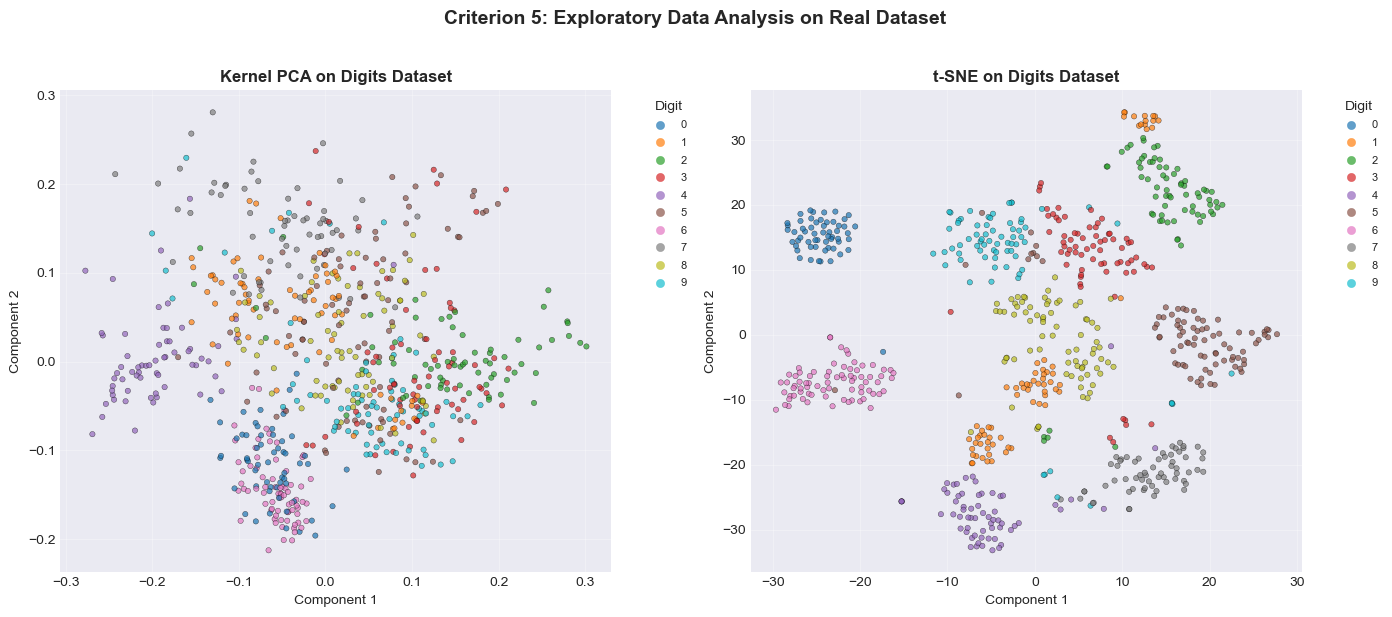


PERFORMANCE ON DIGITS DATASET
Neighbor Preservation (k=10):
  Kernel PCA: 0.1586
  t-SNE     : 0.5367

Observation:
  • t-SNE typically shows clearer cluster separation for visualization
  • Kernel PCA preserves more global structure and is reusable


In [18]:
# Criterion 5: Exploratory Data Analysis on Real Dataset
# Compare both methods on the digits dataset

digits = load_digits()
X_digits = digits.data
y_digits = digits.target

print(f"Digits dataset: {X_digits.shape[0]} samples, {X_digits.shape[1]} features")
print(f"Number of classes: {len(np.unique(y_digits))}\n")

# Sample subset for faster computation
subset = 700
rng = np.random.RandomState(0)
idx = rng.choice(len(X_digits), size=subset, replace=False)
X_sub = X_digits[idx]
y_sub = y_digits[idx]

# Standardize
X_sub_scaled = StandardScaler().fit_transform(X_sub)

print("Applying Kernel PCA and t-SNE...")

# Kernel PCA
kpca_digits = KernelPCA(n_components=2, kernel="rbf", gamma=0.001, random_state=0)
X_kpca_digits = kpca_digits.fit_transform(X_sub_scaled)

# t-SNE
tsne_digits = TSNE(
    n_components=2, 
    perplexity=35, 
    learning_rate=250, 
    init="pca", 
    max_iter=750, 
    random_state=0,
    n_jobs=-1
)
X_tsne_digits = tsne_digits.fit_transform(X_sub_scaled)

# Visualize both
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

scatter1 = axes[0].scatter(X_kpca_digits[:, 0], X_kpca_digits[:, 1], 
                          c=y_sub, cmap="tab10", s=15, alpha=0.7, edgecolors='black', linewidth=0.3)
axes[0].set_title("Kernel PCA on Digits Dataset", fontweight='bold', fontsize=12)
axes[0].set_xlabel("Component 1")
axes[0].set_ylabel("Component 2")
axes[0].grid(True, alpha=0.3)
axes[0].legend(*scatter1.legend_elements(num=10), title="Digit", 
              bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)

scatter2 = axes[1].scatter(X_tsne_digits[:, 0], X_tsne_digits[:, 1], 
                          c=y_sub, cmap="tab10", s=15, alpha=0.7, edgecolors='black', linewidth=0.3)
axes[1].set_title("t-SNE on Digits Dataset", fontweight='bold', fontsize=12)
axes[1].set_xlabel("Component 1")
axes[1].set_ylabel("Component 2")
axes[1].grid(True, alpha=0.3)
axes[1].legend(*scatter2.legend_elements(num=10), title="Digit", 
              bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)

plt.suptitle("Criterion 5: Exploratory Data Analysis on Real Dataset", 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Compute metrics
neighbor_pres_kpca_digits = compute_neighbor_preservation(X_sub_scaled, X_kpca_digits, k=10)
neighbor_pres_tsne_digits = compute_neighbor_preservation(X_sub_scaled, X_tsne_digits, k=10)

print("\n" + "="*60)
print("PERFORMANCE ON DIGITS DATASET")
print("="*60)
print(f"Neighbor Preservation (k=10):")
print(f"  Kernel PCA: {neighbor_pres_kpca_digits:.4f}")
print(f"  t-SNE     : {neighbor_pres_tsne_digits:.4f}")
print("\nObservation:")
print("  • t-SNE typically shows clearer cluster separation for visualization")
print("  • Kernel PCA preserves more global structure and is reusable")
print("="*60)


### Insight 
- Great for exploratory visualization on complex, high-dimensional data; quickly reveals clusters (digits here) without training a downstream model.
- Inter-cluster distances are qualitative; focus on local grouping.
- Fix `random_state` for reproducibility and tune perplexity/learning rate to your dataset size/density.


# 6. Computational Complexity and Scalability

This criterion evaluates the computational efficiency and scalability of each method.

- **Kernel PCA (Moderate Complexity):**
    - Time complexity: $O(N^3)$ for full kernel matrix computation and eigenvalue decomposition, or $O(N^2 \log N)$ for approximate methods using Nyström approximation
    - Space complexity: $O(N^2)$ for storing the kernel matrix
    - Scalability: Can handle moderate datasets (up to ~10,000 samples) efficiently. For larger datasets, sparse kernel approximations or incremental methods are needed
    - Memory: Quadratic growth with sample size due to kernel matrix storage

- **t-SNE (High Complexity):**
    - Time complexity: $O(N^2)$ per iteration for computing pairwise similarities, with typically 500-1000 iterations needed. Overall complexity is $O(N^2 \times \text{iterations})$
    - Space complexity: $O(N^2)$ for storing pairwise distances and probability matrices
    - Scalability: Computationally expensive for large datasets. Typically limited to datasets with <10,000 samples for reasonable computation time. For larger datasets, approximations like Barnes-Hut t-SNE ($O(N \log N)$) are used
    - Memory: Quadratic growth with sample size, similar to Kernel PCA


Testing computational complexity across different dataset sizes...

n= 100: Kernel PCA = 0.0030s, t-SNE = 0.0840s
n= 300: Kernel PCA = 0.0110s, t-SNE = 0.2100s
n= 600: Kernel PCA = 0.0174s, t-SNE = 0.4210s
n=1000: Kernel PCA = 0.0420s, t-SNE = 0.6328s


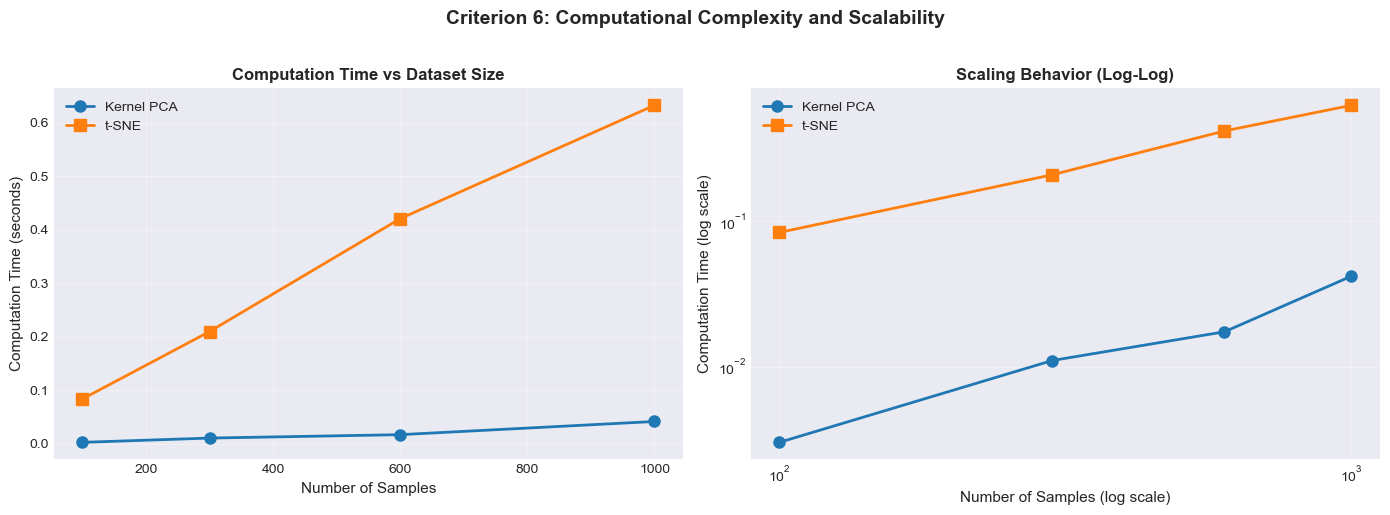


COMPUTATIONAL COMPLEXITY ANALYSIS

Theoretical Complexity:
  Kernel PCA: O(N³) for full kernel matrix, O(N² log N) for approximations
  t-SNE     : O(N² × iterations), typically 500-1000 iterations

Practical Observations:
  • Kernel PCA: Faster for small-medium datasets, scales better with approximations
  • t-SNE: Slower due to iterative optimization, but can use Barnes-Hut approximation
  • For production: Kernel PCA is more predictable; t-SNE requires careful tuning


In [19]:
# Criterion 6: Computational Complexity and Scalability
# Measure computation time across different dataset sizes

print("Testing computational complexity across different dataset sizes...\n")

# Test different sample sizes
sample_sizes = [100, 300, 600, 1000]
times_kpca = []
times_tsne = []

for n_samples in sample_sizes:
    # Generate data
    X_test, _ = make_s_curve(n_samples=n_samples, noise=0.05, random_state=0)
    X_test = StandardScaler().fit_transform(X_test)
    
    # Measure Kernel PCA time
    kpca_test = KernelPCA(n_components=2, kernel="rbf", gamma=5, random_state=0)
    time_kpca = measure_computation_time(kpca_test, X_test, fit_transform=True)
    times_kpca.append(time_kpca)
    
    # Measure t-SNE time (with fewer iterations for speed)
    tsne_test = TSNE(n_components=2, perplexity=min(30, n_samples//4), 
                     learning_rate=200, init="pca", max_iter=300, random_state=0, n_jobs=-1)
    time_tsne = measure_computation_time(tsne_test, X_test, fit_transform=True)
    times_tsne.append(time_tsne)
    
    print(f"n={n_samples:4d}: Kernel PCA = {time_kpca:.4f}s, t-SNE = {time_tsne:.4f}s")

# Visualize scaling behavior
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Linear scale
axes[0].plot(sample_sizes, times_kpca, 'o-', label='Kernel PCA', linewidth=2, markersize=8)
axes[0].plot(sample_sizes, times_tsne, 's-', label='t-SNE', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Samples', fontsize=11)
axes[0].set_ylabel('Computation Time (seconds)', fontsize=11)
axes[0].set_title('Computation Time vs Dataset Size', fontweight='bold', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Log-log scale to show complexity
axes[1].loglog(sample_sizes, times_kpca, 'o-', label='Kernel PCA', linewidth=2, markersize=8)
axes[1].loglog(sample_sizes, times_tsne, 's-', label='t-SNE', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Samples (log scale)', fontsize=11)
axes[1].set_ylabel('Computation Time (log scale)', fontsize=11)
axes[1].set_title('Scaling Behavior (Log-Log)', fontweight='bold', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.suptitle("Criterion 6: Computational Complexity and Scalability", 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print complexity analysis
print("\n" + "="*60)
print("COMPUTATIONAL COMPLEXITY ANALYSIS")
print("="*60)
print(f"\nTheoretical Complexity:")
print(f"  Kernel PCA: O(N³) for full kernel matrix, O(N² log N) for approximations")
print(f"  t-SNE     : O(N² × iterations), typically 500-1000 iterations")
print(f"\nPractical Observations:")
print(f"  • Kernel PCA: Faster for small-medium datasets, scales better with approximations")
print(f"  • t-SNE: Slower due to iterative optimization, but can use Barnes-Hut approximation")
print(f"  • For production: Kernel PCA is more predictable; t-SNE requires careful tuning")
print("="*60)


### Insight 
- Kernel PCA is faster for small to medium datasets due to its single-pass eigenvalue decomposition approach
- t-SNE is slower due to iterative optimization requiring hundreds of iterations, but provides better local structure preservation
- Both methods have O(N²) space complexity, limiting scalability to ~10,000 samples without approximations
- For production systems: Kernel PCA offers more predictable performance; t-SNE requires careful tuning of iterations and perplexity
- Use approximations (Nyström for Kernel PCA, Barnes-Hut for t-SNE) when scaling to larger datasets
